# Dataset Analysis

This notebook is for analyzing and cleansing the [book depository dataset](https://www.kaggle.com/sp1thas/book-depository-dataset). We'll use [Dask](https://dask.org) instead of Pandas due to the dataset size. It will still be executed locally on the Notebook, as this is an exploratory data analysis task, to determine what processing is needed.

## Environment Setup

We'll use some packages that don't come pre-installed with SageMaker, therefore we need to install them. It's important to keep a `requirements.txt` file as we do this, to ensure we can replicate the environment when automating the task. If we commonly need these, it's recommended to create a [lifecycle configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-lifecycle-config.html) to reproduce the environment.

You can find examples of lifecycle configurations [here](https://github.com/aws-samples/amazon-sagemaker-notebook-instance-lifecycle-config-samples). [This support note](https://aws.amazon.com/premiumsupport/knowledge-center/sagemaker-lifecycle-script-timeout/) also shows how to solve a common timeout problem with complex configurations - configuration scripts have a maximum execution time of five minutes, after which they are aborted and the notebook creation fails.

In [1]:
!cat dask-local/requirements.txt

seaborn>=0.10.1
dask[complete]>=2.17.2
langdetect>=1.0.8
cloudpickle>=1.3.0

In [2]:
!pip install -U -q -r dask-local/requirements.txt 

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Initialization

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [4]:
import boto3
import pandas as pd
import dask.dataframe as dd
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, List, Union
from langdetect import detect as detect_lang
import csv
import numpy as np

sns.set_style('darkgrid')

## Retrieve the dataset

The dataset, as explained in [its source](https://www.kaggle.com/sp1thas/book-depository-dataset), is made of several files. `dataset.csv` contains the most fields of the dataset. `authors.csv`, `categories.csv`, `formats.csv` and `places.csv` work as lookup tables for the corresponding fields of the dataset.

We're interested in the `description` field contained in the `dataset.csv` file, but other interesting fields to retrieve are `authors`, `categories`, `lang` and `title`.

First, let's copy the files from S3 to the local disk, for easier manipulation.

In [5]:
raw_bucket = 'zrmar-open-datasets'
raw_s3_path = 'text/kaggle-book-depository/raw'
files = ['categories', 'dataset', 'formats', 'places']

raw_data_dir = os.path.abspath('/home/ec2-user/SageMaker/MUSE-sagemaker-development/data/book-depository/raw')
temp_data_path = os.path.abspath('/tmp/MUSE-sagemaker-development/data/book-depository/cleaned')
cleaned_data_dir = os.path.abspath('/home/ec2-user/SageMaker/MUSE-sagemaker-development/data/book-depository/cleaned')
print(f'The raw dataset will be downloaded to {raw_data_dir}')
print(f'The final cleaned dataset will be saved at {cleaned_data_dir}')

The raw dataset will be downloaded to /home/ec2-user/SageMaker/MUSE-sagemaker-development/data/book-depository/raw
The final cleaned dataset will be saved at /home/ec2-user/SageMaker/MUSE-sagemaker-development/data/book-depository/cleaned


In [6]:
shutil.rmtree(raw_data_dir, ignore_errors=True)
os.makedirs(raw_data_dir)

s3 = boto3.client('s3')
for f in files:
    source_path = f'{raw_s3_path}/{f}.csv'
    print(f'Downloading {source_path}...')
    s3.download_file(raw_bucket, source_path, f'{raw_data_dir}/{f}.csv')

Now that we have the raw CSV, we'll set up some functions for processing the data as we load it
- Converting the strings representation of lists of authors and categories to actual lists

After loading, we also:
- Remove the rows without a description
- Generate counts of authors, categories and # of words in descriptions
- Run a language detection to later check the quality of the language label
- Keep only the rows where either the labeled or supported language is in the list of languages supported by MUSE
- Save a version of the dataset partitioned in several files, which will allow better parallelism.

In [7]:
from langdetect import detect as detect_lang, DetectorFactory
DetectorFactory.seed = 0

def conv_str_int_list(str_int_list: str) -> List[int]:
    try:
        if len(str_int_list[1:-1]):
            return list(map(int, str_int_list[1:-1].split(',')))
        else:
            return []
    except ValueError:
        print(str_int_list)
        raise
        
def detect_descr_lang(row: pd.Series) :
    if row.lang == 'en':  # Accept that english is correct
        return('en')
    else:
        try:
            detected_lang = detect_lang(row.description)  # If it can't detect the language, it returns 'unknown'
        except:
            detected_lang = 'unknown'
        if (row.lang == 'ru' and detected_lang != 'en'):   # If reported russion and detected not english, assume reported is correct
            detected_lang = 'ru'
        elif(detected_lang in {'zh-cn', 'ko', 'zh-tw'}):   # Consolidate all chinese variants and korean as general chinese.
            detected_lang = 'zh'
        return(detected_lang)
    
def detect_df_lang(df: pd.DataFrame) -> pd.DataFrame:
    return(df.apply(detect_descr_lang, axis=1))

def shorten_description(description: str, max_length=1024) -> str:
    return(description[:max_length])

SUPPORTED_LANGUAGES = {'ar', 'nl', 'en', 'de', 'fr', 'it', 'pt', 'es', 'ja', 'ko', 'ru', 'pl', 'tr', 'zh', 'zh-tw', 'th'}

In [11]:
def gen_cleaned_data_v1(source_data_dir: str, dest_data_dir: str, supported_languages: List=SUPPORTED_LANGUAGES, block_size: Union[int, str]='32MB') -> dd.DataFrame: 
    raw_dataset = dd.read_csv(
        f'{source_data_dir}/dataset.csv', header=0, 
        blocksize=block_size,
        usecols=['description', 'authors', 'categories', 'lang', 'title'],
        converters = {
            'authors': conv_str_int_list,
            'categories': conv_str_int_list
        }
    ).repartition(partition_size=block_size)
    dataset = raw_dataset[~ raw_dataset.description.isna()]
    dataset['n_authors'] = dataset.authors.apply(len, meta=pd.Series(name='n_authors', dtype='i4'))
    dataset['n_categories'] = dataset.categories.apply(len, meta=pd.Series(name='n_categories', dtype='i4'))
    dataset['descr_len_words'] = dataset.map_partitions(lambda df: df.description.apply(lambda t: len(t.split(' '))), meta=pd.Series(name='descr_len_words', dtype='i4'))
    dataset['detected_lang'] = dataset.map_partitions(detect_df_lang, meta=pd.Series(name='detected_lang', dtype='U'))
    dataset['lang_match'] = dataset.lang == dataset.detected_lang
    
    dataset = dataset[dataset.lang.isin(supported_languages) | dataset.detected_lang.isin(supported_languages)]
    shutil.rmtree(dest_data_dir, ignore_errors=True)
    dataset.to_csv(f'{dest_data_dir}/dataset-*.csv', compute=True, index=False, quoting=csv.QUOTE_NONNUMERIC)
    return dataset

In [12]:
%%time

gen_cleaned_data_v1(raw_data_dir, temp_data_path)

CPU times: user 15.6 s, sys: 1.22 s, total: 16.8 s
Wall time: 5min 7s


,authors,categories,description,lang,title,n_authors,n_categories,descr_len_words,detected_lang,lang_match
npartitions=68,,,,,,,,,,
,object,object,object,object,object,float64,float64,float64,object,bool
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


After that, we load the cleaned dataset.

In [13]:
analysis_df = dd.read_csv(
   f'{temp_data_path}/dataset-*.csv', header=0,
   converters = {
       'authors': conv_str_int_list,
       'categories': conv_str_int_list
   }
)

First inspection of cleaned dataset:

In [14]:
%%time

rows, columns = (lambda x: (x[0].compute(), x[1]))(analysis_df.shape)
print(f'The dataset has {rows} rows and {columns} columns.\n')
print('Dataset columns:\n   - ' + '\n   - '.join(f'{name}: {dtype}' for (name, dtype) in zip(analysis_df.columns, analysis_df.dtypes)))

The dataset has 1133755 rows and 10 columns.

Dataset columns:
   - authors: object
   - categories: object
   - description: object
   - lang: object
   - title: object
   - n_authors: int64
   - n_categories: int64
   - descr_len_words: int64
   - detected_lang: object
   - lang_match: bool
CPU times: user 706 ms, sys: 0 ns, total: 706 ms
Wall time: 5.95 s


In [15]:
analysis_df.head()

,authors,categories,description,lang,title,n_authors,n_categories,descr_len_words,detected_lang,lang_match
0,"[1, 2]","[235, 3386, 736, 763]",________________________________,en,Journey Into Darkness,2,4,1,en,True
1,[3],"[360, 2632]",A fake marriage is the last thing he wants . ....,en,The Mercenary : Order of the Broken Blade,1,2,17,en,True
2,[4],"[1703, 2771, 2818, 3097]","Once the dust has settled, you'll need to know...",en,100 Skills You'll Need for the End of the Worl...,1,4,97,en,True
3,[5],"[819, 3364, 1853, 2977]",The Daily Mail and the Spectator Book of the Y...,en,How to Land a Plane,1,4,11,en,True
4,[6],"[1694, 1703, 2818]","Easy, do-able, down to earth ideas and suggest...",en,The Sustainable(ish) Living Guide : Everything...,1,3,15,en,True


## Cleansing the Dataset

### Validating that Language Labels are useful

We suspect that the labeled languages do not correspond to the reality, so we'll do some graphical analysis of informed vs detected language to check our hypothesis.

In [16]:
%%time

languages = analysis_df.groupby(['detected_lang', 'lang']).size().reset_index().fillna(0).compute()
languages.columns = ['detected_lang', 'lang', 'num_docs']
languages['lang_match'] = languages.lang == languages.detected_lang

CPU times: user 768 ms, sys: 32.5 ms, total: 801 ms
Wall time: 5.96 s


In [17]:
languages[languages.lang=='zh']

,detected_lang,lang,num_docs,lang_match
14,en,zh,317,False
37,zh,zh,41,True
207,fr,zh,2,False
229,de,zh,1,False
272,unknown,zh,1,False


In [18]:
analysis_df[(analysis_df.lang=='zh') & (~analysis_df.detected_lang.isin({'zh-cn', 'en'}))][['description', 'lang', 'detected_lang']].compute()

,description,lang,detected_lang
4118,关于特斯拉汽车和能源公司的故事简直令人惊叹！你不得不真正钦佩Elon Musk和他在特斯拉的...,zh,zh
974,這本書是一本由Access Consciousness(TM) 的創辦人加利-德格拉斯 從通...,zh,zh
6974,我出生在桂林，一座风光旖旎的城市，一座小富即安的城市。,zh,zh
9910,《篆刻跟我学》是出版过多部畅销篆刻著作的著名书画篆刻家吴颐人先生的力作，遗憾的是，几年来已发...,zh,zh
16127,本书集结旅美华裔女作家余国英女士发表的十篇散文：明亮的天窗、我爱下雨天、乘船访友记、爱之小车...,zh,zh
10969,《大师谈收藏：红木家具投资收藏入门（第二版）》以问答形式分别从红木家具的历史、材质、品类、工...,zh,zh
4549,《盆腔之痛》一书详细介绍了用于男女盆腔疼痛治疗的怀斯- 安德,zh,zh
9711,绘梦会让你为自己的人生吸引更多的目标和正能量。,zh,zh
4210,生活中的趣味化学是由上海市青少年科技教学中心化学教研室编写的一本以生活中的化学知识为切入点，...,zh,zh
11508,哈尔施塔特在中国非常有名，每年都有成千上万的中国人来到奥地利小镇。这是因为2012年由五矿地...,zh,zh


These are the supported languages for which we have no trustworthy data. They'll be dropped from the dataset.

In [19]:
dropped_supported_languages = SUPPORTED_LANGUAGES.difference(languages[languages.lang_match].lang.unique())
dropped_supported_languages

{'ko', 'th', 'zh-tw'}

Now let's look at the languages where we have a mismatch between the labeled language and the detected language:

In [20]:
def plot_mismatched_languages(languages, supported_languages=SUPPORTED_LANGUAGES):
    import matplotlib.ticker as mtick
    
    temp = languages[~languages.lang_match].drop('lang_match', axis=1).groupby('lang').sum().join(languages.drop('lang_match', axis=1).groupby('lang').sum(), how='inner', rsuffix='_total')
    temp['pct_non_match'] = temp.num_docs / temp.num_docs_total
    temp = temp.loc[temp.index.isin(supported_languages)]
    ax = temp.sort_values('pct_non_match').drop(['num_docs_total', 'num_docs'], axis=1).plot.bar(figsize=(20,5))
    ax.set_title("Fraction of documents where detected and labeled language don't match", fontdict={'fontsize': 16})
    ax.set_xlabel('language')
    ax.set_ylabel('fraction')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

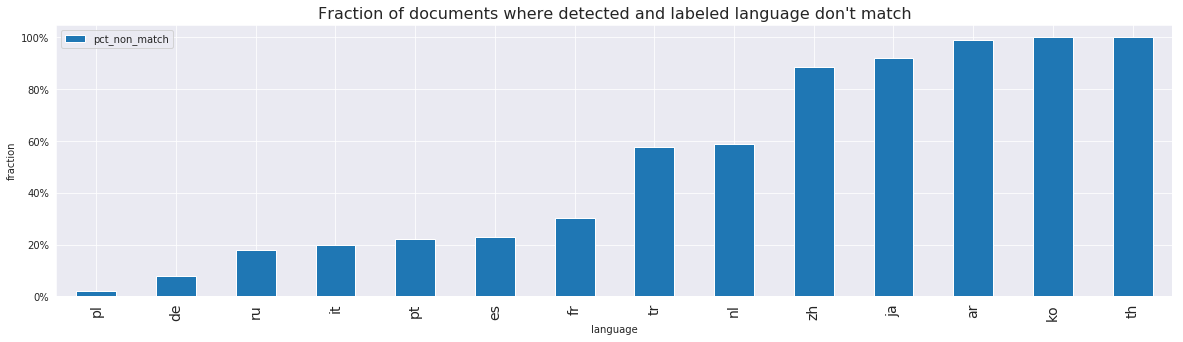

In [21]:
plot_mismatched_languages(languages);

We can see that a number of languages (Japanese, Russian, Arabic, Korean, Thai and Chinese) have most of their data mismatched. From some text inspection, we found that
- The language label is for the book itself, not the description. And even then, it's often applied to bilingual books, such as dictionaries.
- The language detection library is having problems with Russian, maybe because the text is in latin characters, not cyrillic. It detected several other languages for results that could well be Russian with latin characters - and it only seems correct when it detects english.
- The detector library does not return 'zh' for Chinese - it returns 'zh-cn'.
- The chinese text detected as 'ko' is actually chinese. All other text with `lang=zh` and `detected_lang` different is not really chinese.
- For all other languages, most detected languages are correct, save for a small number of mistakes.

Let's also see how the description distribution works in terms of length of characters and words. Note that, **due to the predominance of english, the y axis is log-scaled**.

In [22]:
def plot_ndocs(df, column, ax, supported_languages=SUPPORTED_LANGUAGES):
    _ = df[df[column].isin(supported_languages)].groupby(column).agg({'num_docs': np.sum}).sort_values('num_docs', ascending=False).plot.bar(ax=ax)
    _ = ax.set_yscale('log')
    _ = ax.set_title(f'Based on {column}', fontdict={'fontsize': 16})
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)

def compare_language_info(languages, figsize=(20, 10)):
    figure, ax = plt.subplots(1, 2, figsize=figsize)
    plot_ndocs(languages, 'lang', ax[0])
    plot_ndocs(languages, 'detected_lang', ax[1]);
    figure.suptitle('# of Documents per Language\n(for supported languages)', fontsize=18)
    return(figure)

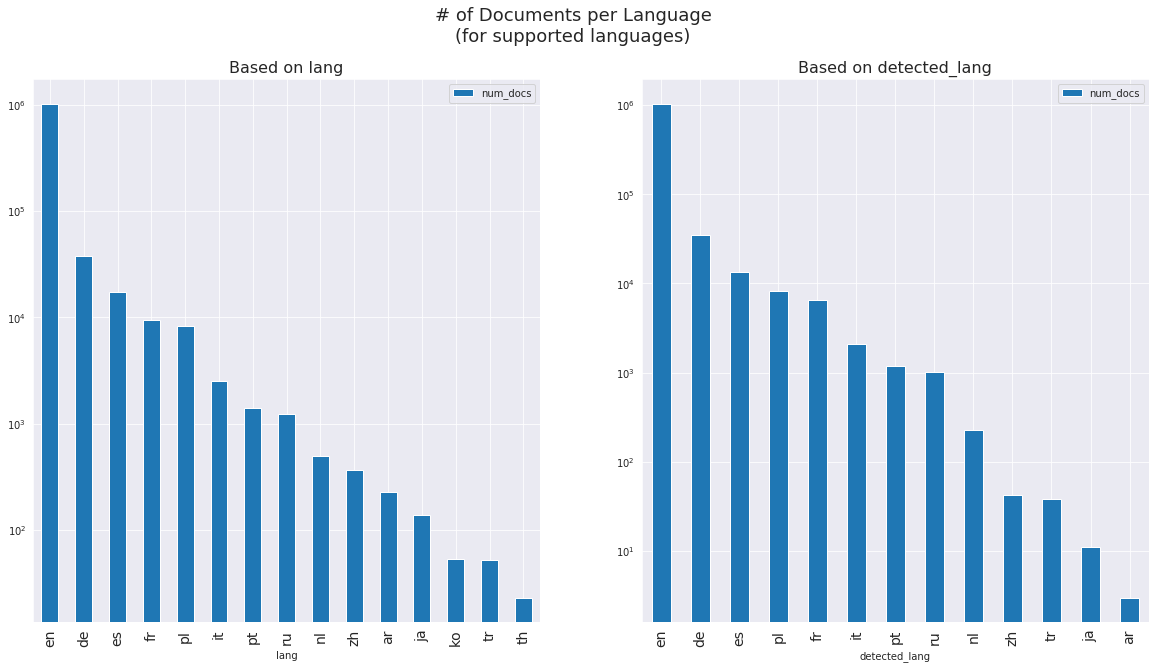

In [23]:
fig = compare_language_info(languages, (20, 10));

In [24]:
def descr_hist(df, length_col, figsize=(20, 10)):
    fig = plt.figure(figsize=(20, 10))
    hists = sns.FacetGrid(df[['detected_lang', length_col]].compute(), col='detected_lang', col_wrap=5, sharex=False, sharey=False)
    _ = hists.map(sns.distplot, length_col, kde=False)
    return fig

<Figure size 1440x720 with 0 Axes>

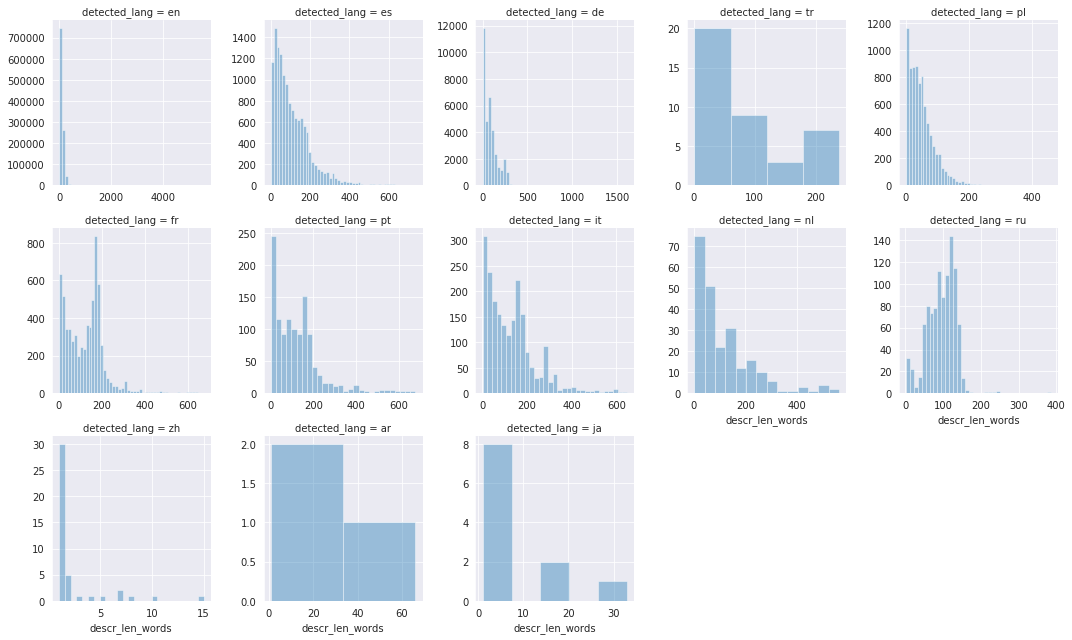

In [25]:
fig = descr_hist(analysis_df[analysis_df.detected_lang.isin(SUPPORTED_LANGUAGES)], 'descr_len_words')

<Figure size 1440x720 with 0 Axes>

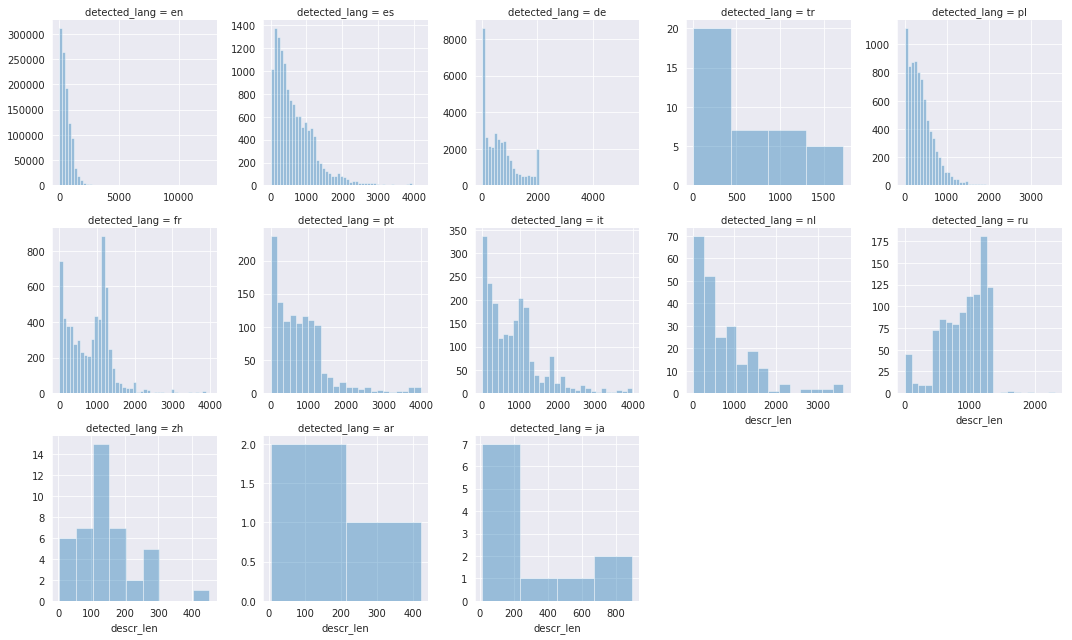

In [26]:
plot_df = analysis_df
plot_df['descr_len'] = plot_df['description'].str.len()
fig = descr_hist(plot_df[plot_df.detected_lang.isin(SUPPORTED_LANGUAGES)], 'descr_len')

### Final Cleansing Transformation

Based on the analysis above, we'll do the following adaptations to the dataset:
- Accept the informed language of russian unless the detected language was english - it's the only detection that seems consistent for russian in latin characters.
- Transform detected 'zh-cn' to 'zh'
- Drop 'ja', 'ar', 'ko', 'th' from our dataset.
- Drop all cases where language detect mismatches labeled language and detected language is English - detected language is usually correct, but there's already too much english on the dataset.
- Drop all cases where detected language is not in the MUSE understood languages
- Drop all cases where length of description is less than 7 words (unless it's Chinese, where our split by spaces does not work).
- Use detected language as the actual description language.

We'll regenerate the dataset to keep the history of improvements made.

In [27]:
def map_lang(series):
    if (series.lang == 'ru' and series.detected_lang != 'en'):
        series.detected_lang = 'ru'
    elif series.detected_lang in('zh-cn', 'ko', 'zh-tw'):
        series.detected_lang = 'zh'
    return series

def fix_det_language(df, supported_languages):
    intermediate = df.apply(map_lang, axis=1)
    intermediate = intermediate[ ~intermediate.lang.isin({'ja', 'ar', 'ko', 'th'})]
    intermediate = intermediate[intermediate.detected_lang.isin(supported_languages)]
    intermediate = intermediate[((intermediate.detected_lang != 'en') | (intermediate.detected_lang == intermediate.lang))]
    intermediate = intermediate[(intermediate.descr_len_words >= 8) | (intermediate.detected_lang == 'zh')]
    return(intermediate)

def gen_cleaned_data_v2(source_data_dir: str, dest_data_dir: str, drop_languages, supported_languages: List=SUPPORTED_LANGUAGES, block_size: Union[int, str]='32MB') -> dd.DataFrame: 
    dataset = dd.read_csv(
        f'{source_data_dir}/dataset.csv', header=0, 
        usecols=['description', 'authors', 'categories', 'lang', 'title'],
        blocksize=block_size,
        converters = {
            'authors': conv_str_int_list,
            'categories': conv_str_int_list,
            'description': shorten_description
        }
    ).repartition(partition_size=block_size)
    dataset = dataset[~ dataset.description.isna()]
    dataset['n_authors'] = dataset.authors.apply(len, meta=pd.Series(name='n_authors', dtype='i4'))
    dataset['n_categories'] = dataset.categories.apply(len, meta=pd.Series(name='n_categories', dtype='i4'))
    dataset['descr_len_words'] = dataset.map_partitions(lambda df: df.description.apply(lambda t: len(t.split(' '))), meta=pd.Series(name='descr_len_words', dtype='i4'))
    dataset['detected_lang'] = dataset.map_partitions(detect_df_lang, meta=pd.Series(name='detected_lang', dtype='U'))
    dataset = dataset[dataset.lang.isin(supported_languages) | dataset.detected_lang.isin(supported_languages)]
    dataset = dataset[~dataset.lang.isin(drop_languages)]  # Dropping languages for which we don't have any trustworthy examples
    dataset = dataset.map_partitions(fix_det_language, meta=dataset, supported_languages=supported_languages)
    shutil.rmtree(dest_data_dir, ignore_errors=True)
    dataset.to_csv(f'{dest_data_dir}/dataset-*.csv', compute=True, index=False, quoting=csv.QUOTE_NONNUMERIC)

In [28]:
%%time 
dropped_supported_languages = dropped_supported_languages.union({'ja', 'ar', 'ko', 'th'})
gen_cleaned_data_v2(raw_data_dir, cleaned_data_dir, dropped_supported_languages)

CPU times: user 18.6 s, sys: 2.13 s, total: 20.7 s
Wall time: 6min 13s


## Cleansed Dataset Analysis

First, let's load the final cleansed dataset.

In [29]:
final_df = dd.read_csv(
   f'{cleaned_data_dir}/dataset-*.csv', header=0,
   converters = {
       'authors': conv_str_int_list,
       'categories': conv_str_int_list
   }
)

In [30]:
final_df.head()

,authors,categories,description,lang,title,n_authors,n_categories,descr_len_words,detected_lang
0,[3],"[360, 2632]",A fake marriage is the last thing he wants . ....,en,The Mercenary : Order of the Broken Blade,1,2,17,en
1,[4],"[1703, 2771, 2818, 3097]","Once the dust has settled, you'll need to know...",en,100 Skills You'll Need for the End of the Worl...,1,4,97,en
2,[5],"[819, 3364, 1853, 2977]",The Daily Mail and the Spectator Book of the Y...,en,How to Land a Plane,1,4,11,en
3,[6],"[1694, 1703, 2818]","Easy, do-able, down to earth ideas and suggest...",en,The Sustainable(ish) Living Guide : Everything...,1,3,15,en
4,[7],"[1843, 2967, 2969]",Mini celebrates 60 amazing years of this iconi...,en,Mini : 60 Years,1,3,20,en


In [31]:
rows, columns = (lambda x: (x[0].compute(), x[1]))(final_df.shape)
print(f'The cleansed dataset has {rows} rows and {columns} columns.\n')

The cleansed dataset has 1042730 rows and 9 columns.



Let's look at the distribution of documents per language for the final dataset.

In [32]:
languages = final_df.groupby(['detected_lang', 'lang']).size().reset_index().fillna(0).compute()
languages.columns = ['detected_lang', 'lang', 'num_docs']
languages['lang_match'] = languages.lang == languages.detected_lang

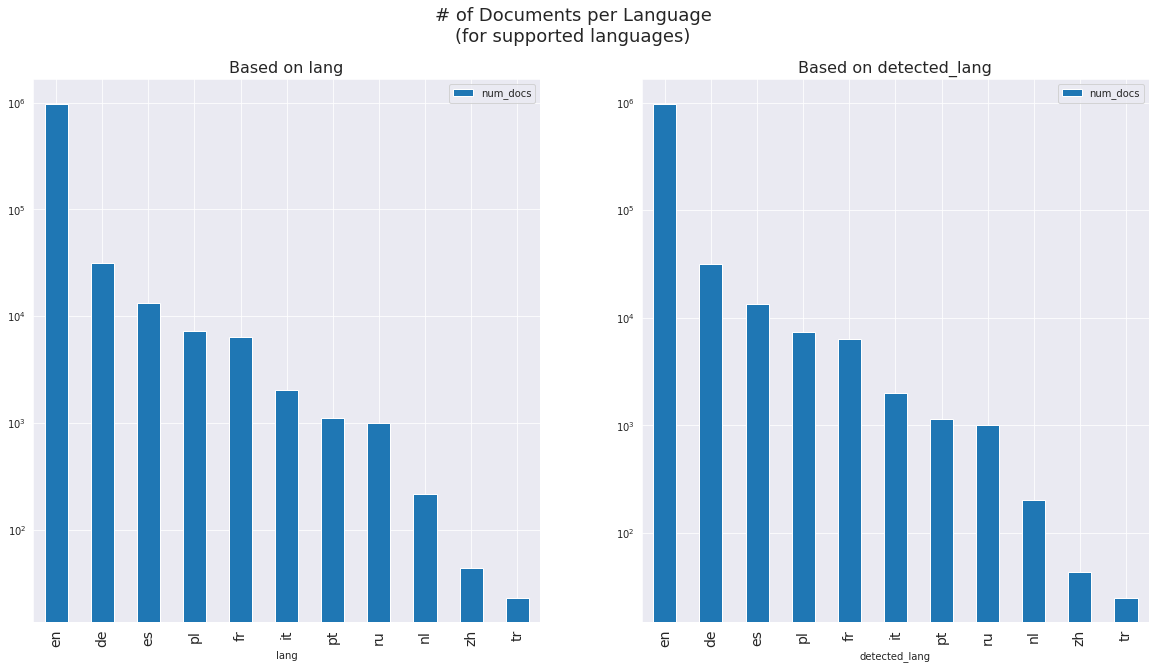

In [33]:
fig = compare_language_info(languages, (20, 10));

After cleansing the data, the labeled and detected languages look similar enough to proceed. The dominance of english, while expected, is a problem we'd normally have to tackle on a real-life situation. For the purposes of showing scaling, we'll keep all the data in.

Next, we'll check the description sizes. Note that words might not be a good measure for languages like chinese, where space usage is not so consistent and characters are often words by themselves.

<Figure size 1440x720 with 0 Axes>

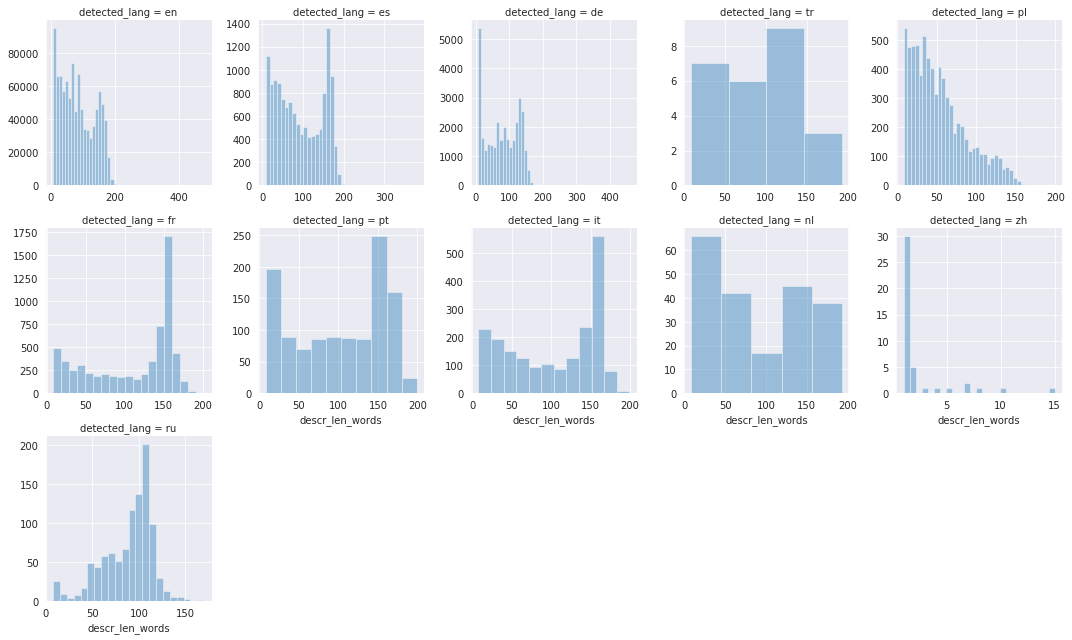

In [34]:
fig = descr_hist(final_df, 'descr_len_words')

<Figure size 1440x720 with 0 Axes>

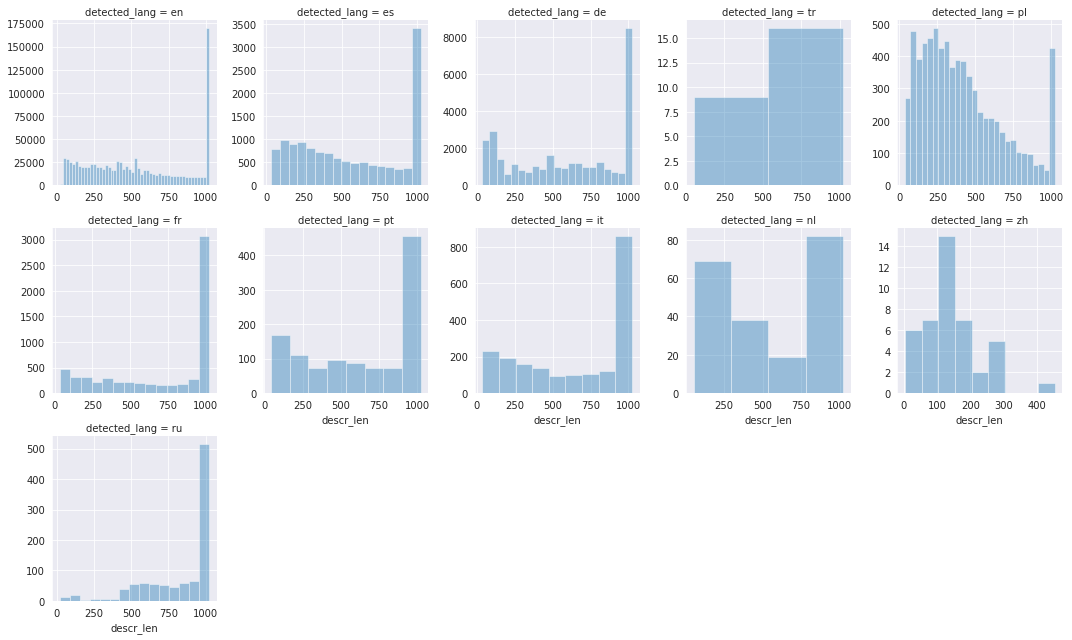

In [35]:
plot_df = final_df
plot_df['descr_len'] = plot_df['description'].str.len()
fig = descr_hist(plot_df, 'descr_len')